In [2]:
import numpy as np
import pylab as plt
from astride import Streak
import h5py

from joblib import Parallel, delayed

In [3]:
# load the dark
dark = np.hstack( h5py.File('rawdark119.hdf5', 'r')['images'].value.mean(0) )  .astype(np.uint16)

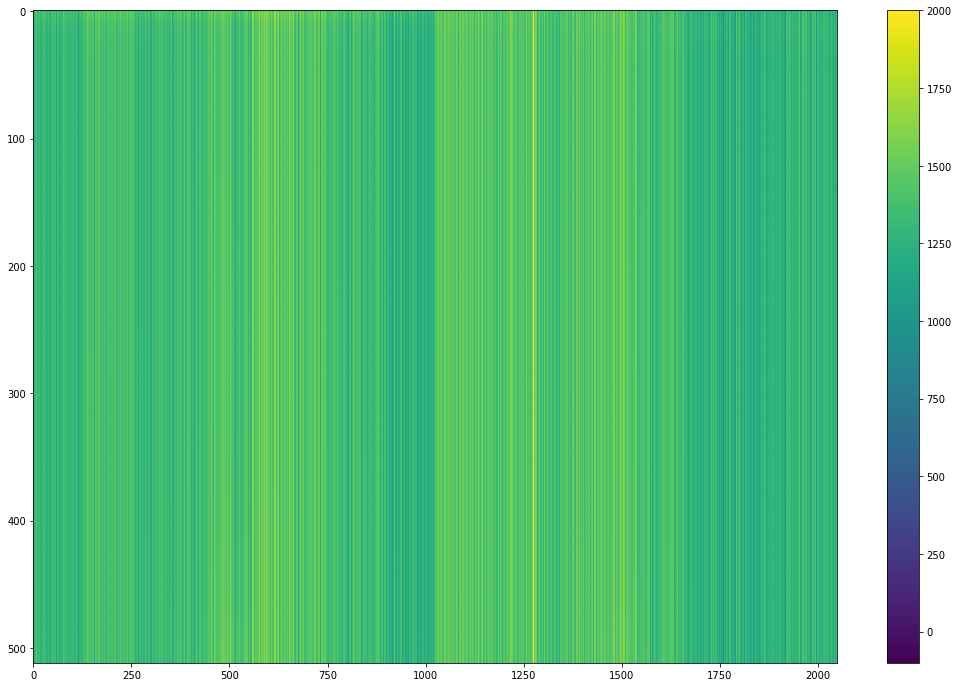

In [4]:
def show_img(img_, **kwargs):
    plt.figure(figsize=(18,12))
    plt.imshow( img_, **kwargs )
    plt.colorbar()
    plt.show()

show_img( dark, aspect='auto', vmax=2000, vmin=-100)

In [5]:
# loveley, lets load the raw data
rawz = h5py.File('raw120-3.hdf5', 'r')['images']
imgs = np.array( [ np.hstack( raw) for raw in rawz ] ) 

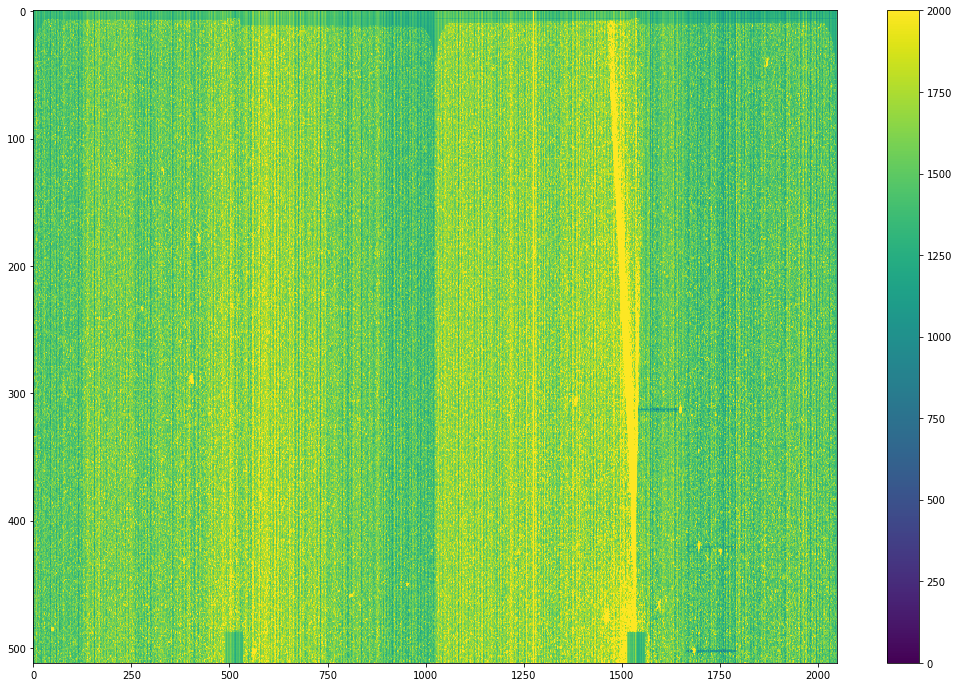

In [6]:
show_img( imgs[20], aspect='auto', vmin=0, vmax=2000)

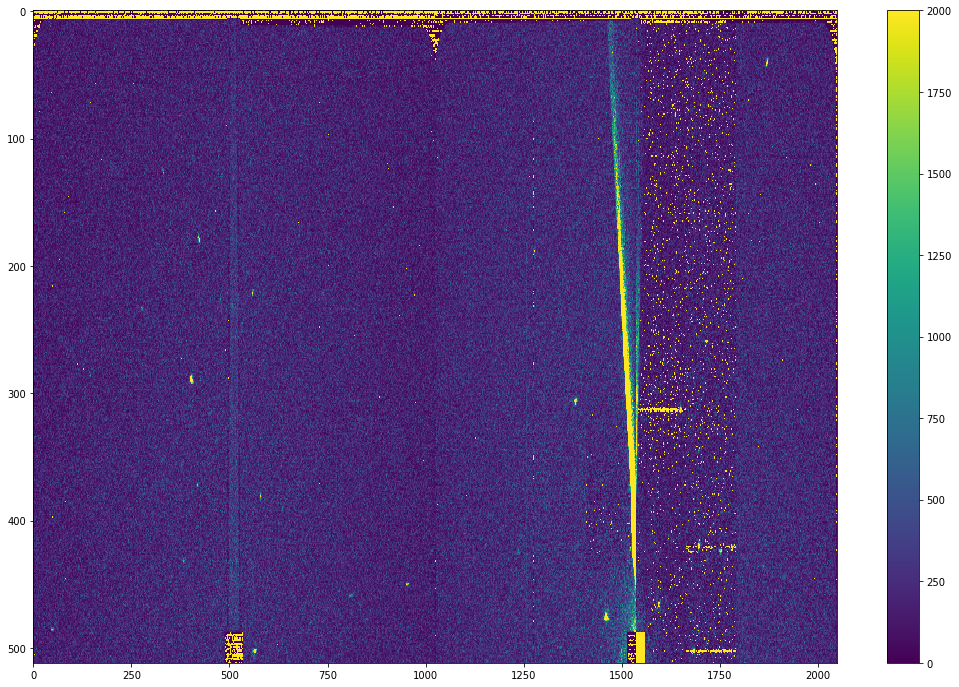

In [7]:
show_img( imgs[20] - dark, aspect='auto', vmin=0, vmax=2000)

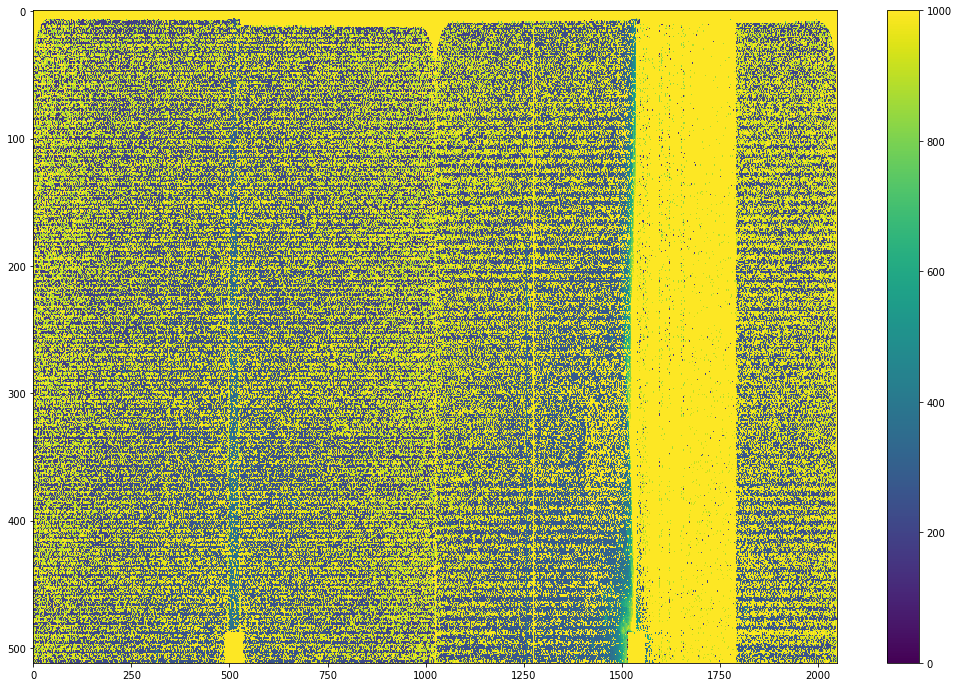

In [8]:
# that still looks pretty shitty.. wonder what the powder looks like
pwdr = np.mean( [ img-dark for img in imgs ] , 0 )
show_img( pwdr, vmin=0, vmax=1000, aspect='auto')


In [9]:
# not sure what it means above...
# oh wait, maybe satur



In [10]:
# funcs for streak masking.. dont look 
img_sh = imgs[0].shape
Y,X = np.indices( img_sh)
pix_pts = np.array( zip(X.ravel(), Y.ravel() ) )

def roll_mask(mpccd_img, border_pad=10, mask_val=0):
    """
    Description
    ===========
    Creates a mask for the CCD. By default the
    masked pixels have value `mask_val` on the
    raw image.
    Parameters
    ==========
    `mpccd_img`    The img that the mask will be made for
    `border_pad`    Add a square border of this length
                    each masked pixel
    `mask_val`    In the raw `mpccd_img`, the masked values will be
                represented by this value (e.g. 0 or -1)
    Return
    ======
    `mask`    A boolean mask value with True/False for
            masked/unmasked values
    """

    mask_template = np.ones_like(mpccd_img)
    mask_template[mpccd_img == mask_val] = 0
    mask = mask_template.copy()

    for i in xrange(border_pad):
        mask = mask * np.roll(mask_template, i, axis=1)
        mask = mask * np.roll(mask_template, -i, axis=1)
        mask = mask * np.roll(mask_template, i, axis=0)
        mask = mask * np.roll(mask_template, -i, axis=0)

    return mask.astype(bool)

def mask_streak( img):
#   make the streak detector
    streak = Streak(img, output_path='.', contour_threshold=5)
    streak.detect()
     
#   make a mask from the streaks
    edges = streak.streaks

    if len(edges) == 0:
        return np.ones_like( img).astype(np.bool)

#   these vertices define polygons surrounding each streak
    verts = [ np.vstack(( edge['x'], edge['y'])).T 
        for edge in edges]

#   make a path object corresponging to each polygon
    paths = [ plt.mpl.path.Path(v) 
        for v in verts ]

#   check if pixel is contained in ANY of the streak polygons
    contains = np.vstack( [ p.contains_points(pix_pts) 
        for p in paths ])
    
    mask = np.any( contains,0).reshape( img_sh)

    # blur this
    mask = roll_mask( np.logical_not(mask), 10)
    
    return mask


def main(imgs, jid):
    m_imgs = []
    for i, img in enumerate(imgs):
        print("proc %d: img %d/%d"%(jid, i+1, len(imgs)))
        mask = mask_streak(img)
        m_imgs.append( mask * img)
    return np.array( m_imgs)


In [13]:
# clean patterns a bit
imgs_drksub_rmhot = np.zeros_like(imgs)
for i,img in enumerate(imgs):
    img = img - dark # sub that dark
    img[ img > 65000] = 0 #   O_o # remove those hots
    imgs_drksub_rmhot[i]=img

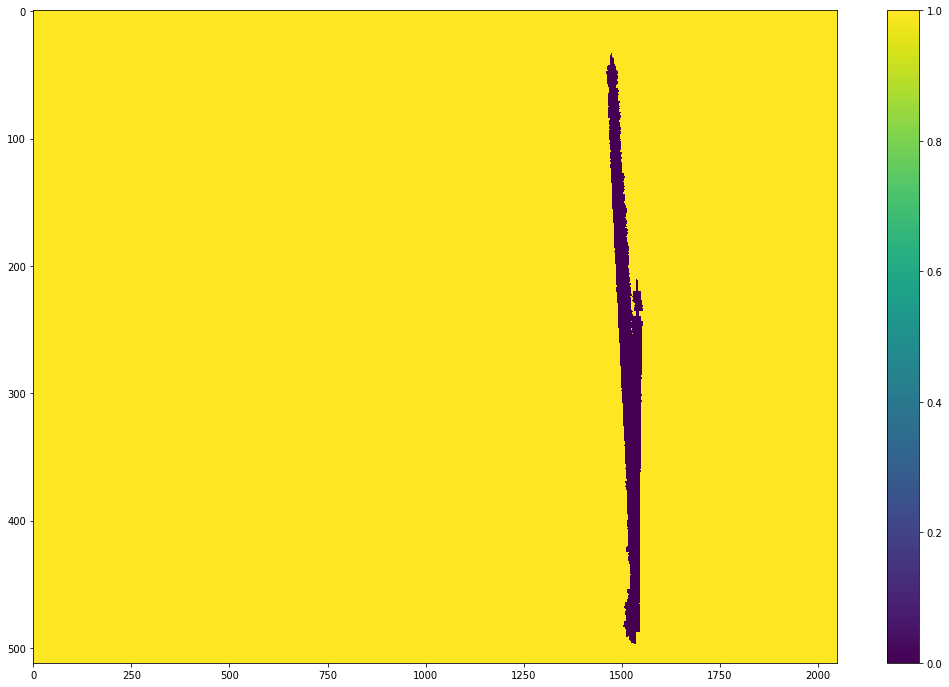

In [14]:
    #check that masker 
m=mask_streak(imgs_drksub_rmhot[20])
show_img( m, aspect='auto')

In [ ]:
%%capture
n_jobs = 22
img_sp = np.array_split( imgs_drksub_rmhot, n_jobs)
results = Parallel(n_jobs=n_jobs)( delayed(main)( img_sp[i], i ) 
    for i in xrange( n_jobs))


In [ ]:
all_m_imgs = np.concatenate( [ r for r in results if r.size ] )


In [257]:
#imgs_rolled = np.zeros_like( imgs )
#for i,img in enumerate(all_m_imgs):
#    mask = roll_mask( img, 10)
#    imgs_rolled[i] =  mask * img

In [ ]:
# read its like 1250 ADU per 1keV photon
show_img( (all_m_imgs[20]/1250.).astype(int), aspect='auto', vmax=15, cmap='gnuplot')

In [ ]:

show_img( (all_m_imgs[80]/1250.).astype(int), aspect='auto', vmax=15, cmap='gnuplot')

In [ ]:

show_img( (all_m_imgs/1250.).sum(0).astype(int), aspect='auto', vmax=30,cmap='gnuplot')

In [359]:
#masks = [] #np.ones_like( all_m_imgs)
#for img in all_m_imgs:
#    m = img != 0
#    masks.append( m )
#masks = np.array(masks)

#weights = np.sum( masks,0)
